In [1]:
from tensorflow.keras.layers import *
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('./dataset/clean-sensors.csv', infer_datetime_format=True, header=0, index_col='datetime')

C:\Users\Bintang\AppData\Local\Temp\ipykernel_24348\3182949423.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv('./dataset/clean-sensors.csv', infer_datetime_format=True, header=0, index_col='datetime')


In [3]:
data.head()

,Temperature,Humidity,Illumination,kat_temperature,kat_humidity,kat_illumination,Kipas,Humidifier,LED
datetime,,,,,,,,,
03/07/2023 0:00:00,28.0,75,76.61,2,2,3,0,0,1
03/07/2023 0:01:00,28.0,75,75.33,2,2,3,0,0,1
03/07/2023 0:02:00,28.0,75,74.49,2,2,3,0,0,1
03/07/2023 0:03:00,28.0,75,74.49,2,2,3,0,0,1
03/07/2023 0:04:00,28.0,75,74.49,2,2,3,0,0,1


In [4]:
data.columns

Index(['Temperature', 'Humidity', 'Illumination', 'kat_temperature',
       'kat_humidity', 'kat_illumination', 'Kipas', 'Humidifier', 'LED'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11507 entries, 03/07/2023 0:00:00 to 10/07/2023 23:59:00
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Temperature       11507 non-null  float64
 1   Humidity          11507 non-null  int64  
 2   Illumination      11063 non-null  float64
 3   kat_temperature   11507 non-null  int64  
 4   kat_humidity      11507 non-null  int64  
 5   kat_illumination  11507 non-null  int64  
 6   Kipas             11507 non-null  int64  
 7   Humidifier        11507 non-null  int64  
 8   LED               11507 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 899.0+ KB


In [6]:
data = data[[col for col in data.columns if not col.startswith('kat_')]]

In [7]:
stats = data.describe()
stats.pop('Kipas')
stats.pop('LED') 
stats.pop('Humidifier')
stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
Temperature,11507.0,30.018954,1.249807,27.20,28.90,30.20,30.80,33.30
Humidity,11507.0,66.055618,5.500173,51.00,62.00,67.00,70.00,76.00
Illumination,11063.0,147.412321,201.545117,28.89,73.24,73.24,76.61,1508.57


In [8]:
train, test = train_test_split(data, test_size=.2, random_state=1)

In [9]:
def format_output(data):
    fan = np.array(data.pop('Kipas'))
    humid = np.array(data.pop('Humidifier'))
    led = np.array(data.pop('LED'))
    return fan, humid, led    

In [10]:
train_label = format_output(train)
test_label = format_output(test)

In [11]:
train_label

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 1, 0, 0], dtype=int64),
 array([0, 1, 0, ..., 1, 1, 0], dtype=int64))

In [12]:
len(train_label[0]) == len(train)

True

In [13]:
scaler = StandardScaler()
scaler.fit(train)

StandardScaler()

In [14]:
x_train = scaler.transform(train)
x_test = scaler.transform(test)

In [15]:
x_train

array([[-0.8958881 ,  0.71388536, -0.37880097],
       [-0.57439694,  0.89633573, -0.36430899],
       [-0.8958881 ,  0.71388536, -0.376767  ],
       ...,
       [ 1.43492276, -1.47551901, -0.35368154],
       [-0.57439694,  0.89633573, -0.36644465],
       [ 0.63119488,  0.16653427,  1.8292167 ]])

In [16]:
print("Shape of x_train before reshaping:", x_train.shape)
print("Shape of x_test before reshaping:", x_test.shape)

# Reshape the data to be 3D for LSTM input
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

# Check the shape after reshaping
print("Shape of x_train after reshaping:", x_train.shape)
print("Shape of x_test after reshaping:", x_test.shape)


Shape of x_train before reshaping: (9205, 3)
Shape of x_test before reshaping: (2302, 3)
Shape of x_train after reshaping: (9205, 1, 3)
Shape of x_test after reshaping: (2302, 1, 3)


In [17]:
inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))
bc = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.SGD(learning_rate=.0001, momentum=.9)

# Siamese neural network

In [18]:
def base_model(input_layer):
    x = Conv1D(32, 5, 1, 'causal', activation='relu')(input_layer)
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(64, return_sequences=True)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    return x
    

In [19]:
def final_model(input_layer):
    x = base_model(input_layer)
    fan_output = Dense(1, activation='sigmoid', name='fan_output')(x)
    led_output = Dense(1, activation='sigmoid', name='led_output')(x)   
    humid = Dense(1, activation='sigmoid', name='humid_output')(x)
    return tf.keras.Model(inputs=input_layer, outputs=[fan_output, led_output, humid])

In [20]:
model = final_model(inputs)
model.compile(
    loss= {
        'fan_output': bc, 
        'led_output': bc, 
        'humid_output': bc, 
    },
    optimizer=opt,
    metrics={
        'fan_output': 'accuracy', 
        'led_output': 'accuracy', 
        'humid_output': 'accuracy',
    }
)

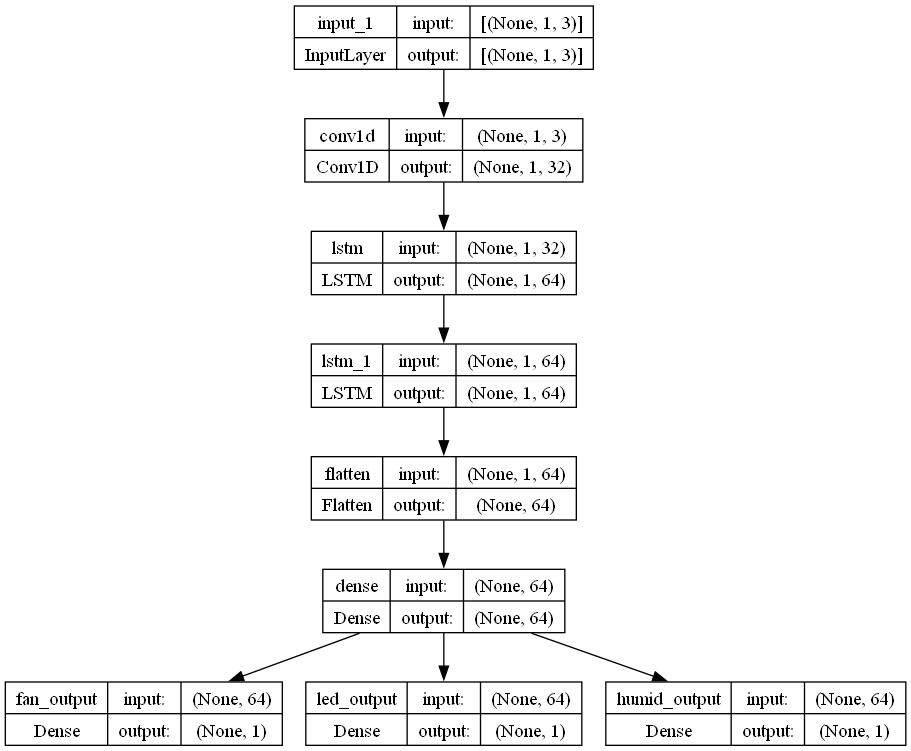

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [22]:
H = model.fit(
    x=x_train,
    y=train_label,
    epochs=25,
    # validation_data=(x_test, test_label),
    validation_split=.2,
    verbose=2
)

Epoch 1/25
231/231 - 10s - loss: nan - fan_output_loss: nan - led_output_loss: nan - humid_output_loss: nan - fan_output_accuracy: 0.9667 - led_output_accuracy: 0.7397 - humid_output_accuracy: 0.2720 - val_loss: nan - val_fan_output_loss: nan - val_led_output_loss: nan - val_humid_output_loss: nan - val_fan_output_accuracy: 0.9772 - val_led_output_accuracy: 0.7507 - val_humid_output_accuracy: 0.2553 - 10s/epoch - 42ms/step
Epoch 2/25
231/231 - 3s - loss: nan - fan_output_loss: nan - led_output_loss: nan - humid_output_loss: nan - fan_output_accuracy: 0.9694 - led_output_accuracy: 0.7397 - humid_output_accuracy: 0.2708 - val_loss: nan - val_fan_output_loss: nan - val_led_output_loss: nan - val_humid_output_loss: nan - val_fan_output_accuracy: 0.9772 - val_led_output_accuracy: 0.7507 - val_humid_output_accuracy: 0.2553 - 3s/epoch - 14ms/step
Epoch 3/25
231/231 - 6s - loss: nan - fan_output_loss: nan - led_output_loss: nan - humid_output_loss: nan - fan_output_accuracy: 0.9694 - led_outpu

In [23]:
predictions = model.predict(x_test)

72/72 [==============================] - 1s 6ms/step


In [24]:
model.evaluate(x_test, test_label)

72/72 [==============================] - 1s 9ms/step - loss: nan - fan_output_loss: nan - led_output_loss: nan - humid_output_loss: nan - fan_output_accuracy: 0.9683 - led_output_accuracy: 0.7242 - humid_output_accuracy: 0.2802


[nan,
 nan,
 nan,
 nan,
 0.9682884216308594,
 0.7241529226303101,
 0.2801911234855652]

In [25]:
predictions

[array([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], dtype=float32),
 array([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], dtype=float32),
 array([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], dtype=float32)]